In [1]:
import math
import torch
import ntwrk
from ntwrk.bayesopt import BayesOpt, expected_improvement, max_mean

import gym
import sys
sys.path.append("../../ntwrk/gym/")
import multi_sender_sim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

n_sender=2

env = gym.make("Sndr-v0")
env.reset(n_sender)

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

In [2]:
max_x = 1000
n_start = 3
rates = torch.rand(n_start)
rwrds = torch.zeros(n_start)
for rnd in range(n_start):
    curr_rates = rates[rnd].mul(max_x).expand(n_sender, 1)
    rwrds[rnd] = torch.tensor(env.step(curr_rates)[1]).sum()
    

In [3]:
rates

tensor([0.3861, 0.2945, 0.1877])

In [4]:
rwrds

tensor([-1.2718, -1.1347, -1.1706])

In [13]:
bo = BayesOpt(rates.mul(max_x), rwrds, normalize=True, max_x=max_x, acquisition=expected_improvement,
             max_jump=300)

torch.Size([2, 1])
next rate =  tensor([[0.],
        [0.]])


/home/vagrant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


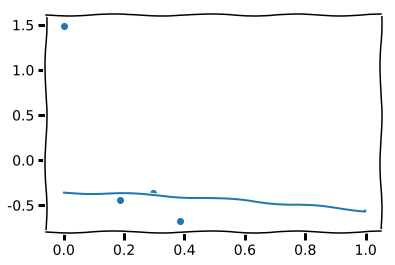

torch.Size([2, 1])
next rate =  tensor([[0.],
        [0.]])


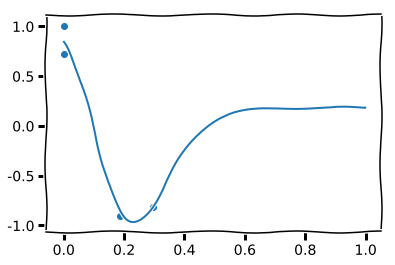

torch.Size([2, 1])
next rate =  tensor([[0.],
        [0.]])


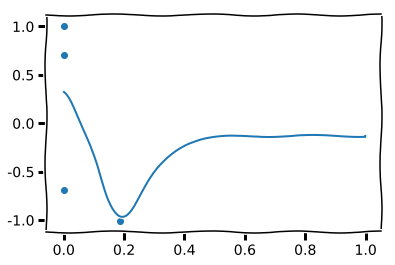

torch.Size([2, 1])
next rate =  tensor([[0.],
        [0.]])


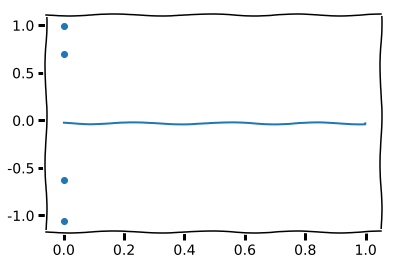

torch.Size([2, 1])
next rate =  tensor([[265.3266],
        [265.3266]])


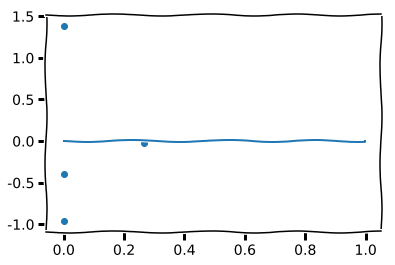

torch.Size([2, 1])
next rate =  tensor([[488.6241],
        [488.6241]])


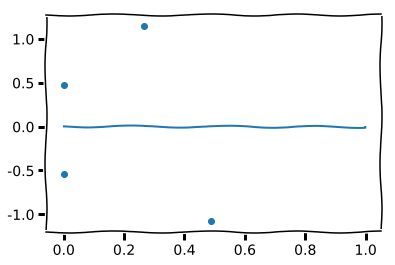

torch.Size([2, 1])
next rate =  tensor([[188.6241],
        [188.6241]])


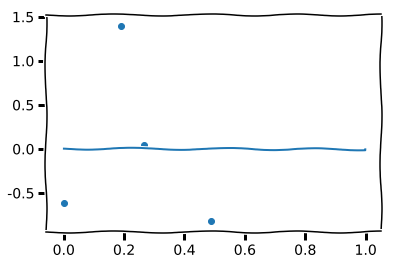

torch.Size([2, 1])
next rate =  tensor([[0.],
        [0.]])


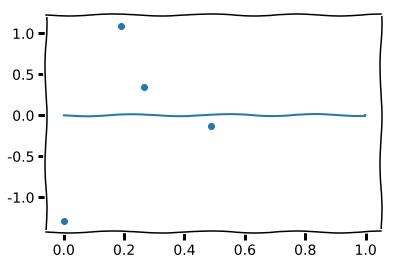

torch.Size([2, 1])
next rate =  tensor([[192.9648],
        [192.9648]])


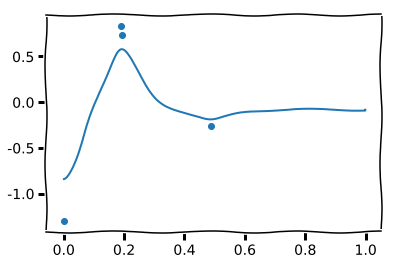

torch.Size([2, 1])
next rate =  tensor([[180.8363],
        [180.8363]])


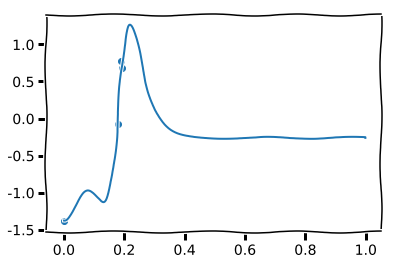

In [14]:
rnds = 10
saved_rwrds = torch.zeros(rnds, n_sender)
test_points = torch.arange(1, 1000).float().div(max_x)
for ii in range(rnds):
    bo.train_surrogate(iters=500, overwrite=True)
    ac_rate = bo.acquire(explore=0.1).unsqueeze(0)
    
    next_rate = ac_rate.expand(n_sender, 1)
    print(next_rate.shape)
    print("next rate = ", next_rate)
    rwrds = torch.tensor(env.step(next_rate)[1])
    saved_rwrds[ii, :] = rwrds
    

#     print(ac_rate)
#     print(rwrd)
    bo.update_obs(ac_rate, rwrds.sum().unsqueeze(-1).float(), max_obs=4)
    
    with plt.xkcd():
        pred_mean = bo.get_pred_dist(test_points).mean

        plt.scatter(bo.train_x, bo.train_y)
        plt.plot(test_points, pred_mean.detach())
        plt.show()
    

In [15]:
saved_rwrds.cumsum(0)

tensor([[-0.8309,  0.4981],
        [-1.5565,  0.7655],
        [-2.1551,  0.3259],
        [-2.9371, -0.1157],
        [-3.3957, -0.5729],
        [-4.1057, -1.1837],
        [-4.7597, -0.8119],
        [-7.0669, -0.8045],
        [-7.6094, -0.6372],
        [-8.2982, -1.0202]])

In [16]:
saved_rwrds

tensor([[-0.8309,  0.4981],
        [-0.7256,  0.2674],
        [-0.5986, -0.4396],
        [-0.7821, -0.4416],
        [-0.4586, -0.4572],
        [-0.7100, -0.6109],
        [-0.6540,  0.3719],
        [-2.3072,  0.0074],
        [-0.5426,  0.1673],
        [-0.6887, -0.3831]])

In [17]:
saved_rwrds.shape

torch.Size([10, 2])

/home/vagrant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


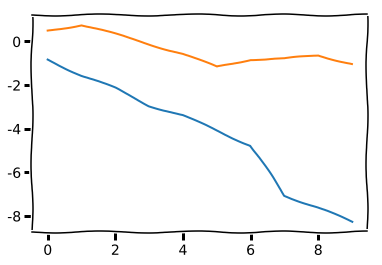

In [18]:
plt.plot(saved_rwrds.cumsum(0))
plt.show()